# Claims data, Fitness Tracker data
## Statistical learning (Tree based, K-means clustering, Hierarchical clustering)

## Part 1: Supervised learning using a tree-based model

### 1.1 Import libraries

In [52]:
# Import libraries
# General
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import seaborn as sns

# For tree-based model 
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error


### 1.2 Import and explore the insurance claim data

In [53]:
# Import data
df = pd.read_csv('../input/claims-data/ClaimsData.csv', sep=",")

In [54]:
# Explore the size of the data set
df.shape

(1500, 7)

In [55]:
# Explore type of data and feature names
df.head()

Claim Category   Mileage  AgeP  ModelYear PreOwned ServHist
0  42089.53    Sedan   99754.4    40       2016      Yes      Yes
1  24097.69      SAV   63926.9    43       2018       No       No
2  19190.63    Small  134829.8    28       2018       No      Yes
3  20574.27    Small   59107.4    28       2018       No      Yes
4  26734.33      SAV  132746.9    22       2017       No      Yes

 #### 1.3 Plot the data

**a) Visualise the continuous variables on a scatterplot**

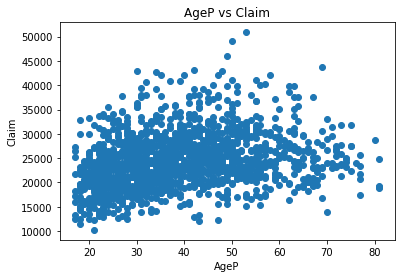

In [56]:
# Plot a scatterplot of y vs the continuous variables (Mileage and AgeP)
plt.scatter(df.loc[:,"Mileage"],df.loc[:,"Claim"])
plt.title('Mileage vs Claim')
plt.ylabel('Claim')
plt.xlabel('Mileage')
plt.show()

plt.scatter(df.loc[:,"AgeP"],df.loc[:,"Claim"])
plt.title('AgeP vs Claim')
plt.ylabel('Claim')
plt.xlabel('AgeP')
plt.show()

**b) Compare the mean claim amount for categorical variables**  

In [57]:
# Calculate the mean claim amount of pre-owned and not pre-owned vehicles
df.groupby('PreOwned')['Claim'].mean().round(2)

PreOwned
No     23435.09
Yes    26987.04
Name: Claim, dtype: float64

In [58]:
# Plot the pre-owned vs non-pre-owned vehicles
not_preowned = df.groupby('PreOwned')['Claim'].mean()[0]
preowned = df.groupby('PreOwned')['Claim'].mean()[1]

plt.bar(np.arange(2), [not_preowned, preowned], width=0.5)
plt.xticks(np.arange(2),("not pre-owned", "pre-owned"))
plt.title('Mean claim with regards to pre-owning')
plt.ylabel('Claim')

plt.show()

### The mean claim pre-owned cars is more than the mean claim of new cars

In [59]:
# Calculate the mean claim amount of vehicles with and without service histories
df.groupby('ServHist')['Claim'].mean().round(2)

ServHist
No     24368.47
Yes    24780.54
Name: Claim, dtype: float64

In [60]:
# Plot the mean claim amount of vehicles with and without service histories
no_servhist = df.groupby('ServHist')['Claim'].mean()[0]
servhist = df.groupby('ServHist')['Claim'].mean()[1]

plt.bar(np.arange(2), [no_servhist, servhist],color="red", width=0.5)
plt.xticks(np.arange(2),("With service history", "Without service history"))
plt.title('Mean claim with regards to service history')
plt.ylabel('Claim')

plt.show()

### There is no difference in the mean claim amount for cars with or without a service history

In [61]:
# Calculate the mean claim amount of vehicles in each category
df.groupby('Category')['Claim'].mean().round(2)


Category
SAV      25567.22
SUV      29439.96
Sedan    23759.34
Small    21458.09
Super    33107.50
Name: Claim, dtype: float64

In [62]:
# Calculate the mean claim amount of vehicles for each model year
df.groupby('ModelYear')['Claim'].mean().round(2)

ModelYear
2011    21251.20
2012    22089.08
2013    22797.42
2014    24559.40
2015    24396.63
2016    24930.40
2017    24859.32
2018    24844.63
2019    25487.11
Name: Claim, dtype: float64

#### 1.4 Prepare the data

In [63]:
# Check that there are no missing values
print(df.isnull().sum()) 

Claim        0
Category     0
Mileage      0
AgeP         0
ModelYear    0
PreOwned     0
ServHist     0
dtype: int64


In [64]:
# One-hot encode the "Category" variable and add the encoded feature to the dataframe 

ohe = OneHotEncoder(categories='auto')
Xd = ohe.fit_transform(df.Category.values.reshape(-1,1)).toarray()
df_ohe = pd.DataFrame(Xd, columns = ohe.get_feature_names())

# Add encoded feature to the dataframe and view the new dataframe with .head()

df = pd.concat([df, df_ohe], axis=1)
df.head()

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Claim Category   Mileage  AgeP  ModelYear PreOwned ServHist  x0_SAV  \
0  42089.53    Sedan   99754.4    40       2016      Yes      Yes     0.0   
1  24097.69      SAV   63926.9    43       2018       No       No     1.0   
2  19190.63    Small  134829.8    28       2018       No      Yes     0.0   
3  20574.27    Small   59107.4    28       2018       No      Yes     0.0   
4  26734.33      SAV  132746.9    22       2017       No      Yes     1.0   

   x0_SUV  x0_Sedan  x0_Small  x0_Super  
0     0.0       1.0       0.0       0.0  
1     0.0       0.0       0.0       0.0  
2     0.0       0.0       1.0       0.0  
3     0.0       0.0       1.0       0.0  
4     0.0       0.0       0.0       0.0

In [65]:
# Split data into features (X) and response (y) 
X = df.iloc[:, np.r_[2:4, 7:12]]
y = df.loc[:, ["Claim"]]

In [66]:
X.head()

Mileage  AgeP  x0_SAV  x0_SUV  x0_Sedan  x0_Small  x0_Super
0   99754.4    40     0.0     0.0       1.0       0.0       0.0
1   63926.9    43     1.0     0.0       0.0       0.0       0.0
2  134829.8    28     0.0     0.0       0.0       1.0       0.0
3   59107.4    28     0.0     0.0       0.0       1.0       0.0
4  132746.9    22     1.0     0.0       0.0       0.0       0.0

In [67]:
y.head()

Claim
0  42089.53
1  24097.69
2  19190.63
3  20574.27
4  26734.33

#### 1.5 Split the data into a training and test set

In [68]:
# Split the data into the training set and test set 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
print(X_train.shape,X_test.shape)

(1125, 7) (375, 7)


In [71]:
# Finding the optimal number of leaf nodes
nodes = [node for node in range(2,35)]     

regs = []
for node in nodes:
    reg2 = DecisionTreeRegressor(random_state=0, 
                                         max_leaf_nodes=node)
    reg2.fit(X_train, y_train)
    regs.append(reg2)

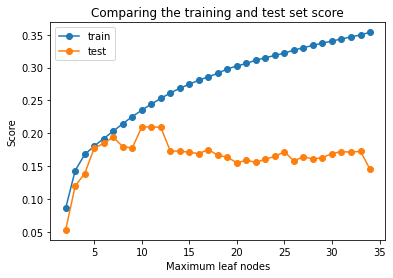

In [72]:
# Visualise the performance of each subtree on the training and test set
train_scores = [reg.score(X_train, y_train) for reg in regs]
test_scores = [reg.score(X_test, y_test) for reg in regs]

fig, ax = plt.subplots()
ax.set_xlabel("Maximum leaf nodes")
ax.set_ylabel("Score")
ax.set_title("Comparing the training and test set score")
ax.plot(nodes, train_scores, marker='o', label="train")
ax.plot(nodes, test_scores, marker='o', label="test")
ax.legend()
plt.show()

In [73]:
# To find the optimal maximum leaf nodes, cross validation is applied
validation_scores = []
for node in nodes:
    reg3 = DecisionTreeRegressor(random_state=0, max_leaf_nodes=node)
    score = cross_val_score(estimator=reg3, X=X_train, y=y_train, cv=5)   
    validation_scores.append(score.mean())

In [74]:
# Visualise the validation score in relation to maximum leaf nodes
plt.figure()
plt.xlabel("Maximum leaf nodes")
plt.ylabel("Validation score")
plt.title("Validation scores at different maximum leaf nodes")
plt.plot(nodes, validation_scores, marker='o', label="train")
plt.legend()
plt.show()

In [75]:
# Obtain the maximum leaf nodes with the highest validation score
nodes_optimum = nodes[validation_scores.index(max(validation_scores))]
print(nodes_optimum)

22


In [76]:
# Use the optimum maximum leaf nodes to fit the tree 
reg4 = DecisionTreeRegressor(random_state=0, max_leaf_nodes=nodes_optimum)
reg4.fit(X_train, y_train)

DecisionTreeRegressor(max_leaf_nodes=22, random_state=0)

In [78]:
# Show the first few levels of the tree
plt.figure(figsize=[7,5], dpi=300)
plot_tree(reg4, max_depth=2,
          feature_names=X_train.columns, 
          filled=True,impurity=False)
plt.show()

1.  The node to the left indicates that the above criterion is true while the node to the right indicates that it is false.
   * left = true
   * right = false
2. For nodes splitting on a categorical variable:
   * node left of `<= 0.5` = 0
   * node right of `<= 0.5` = 1

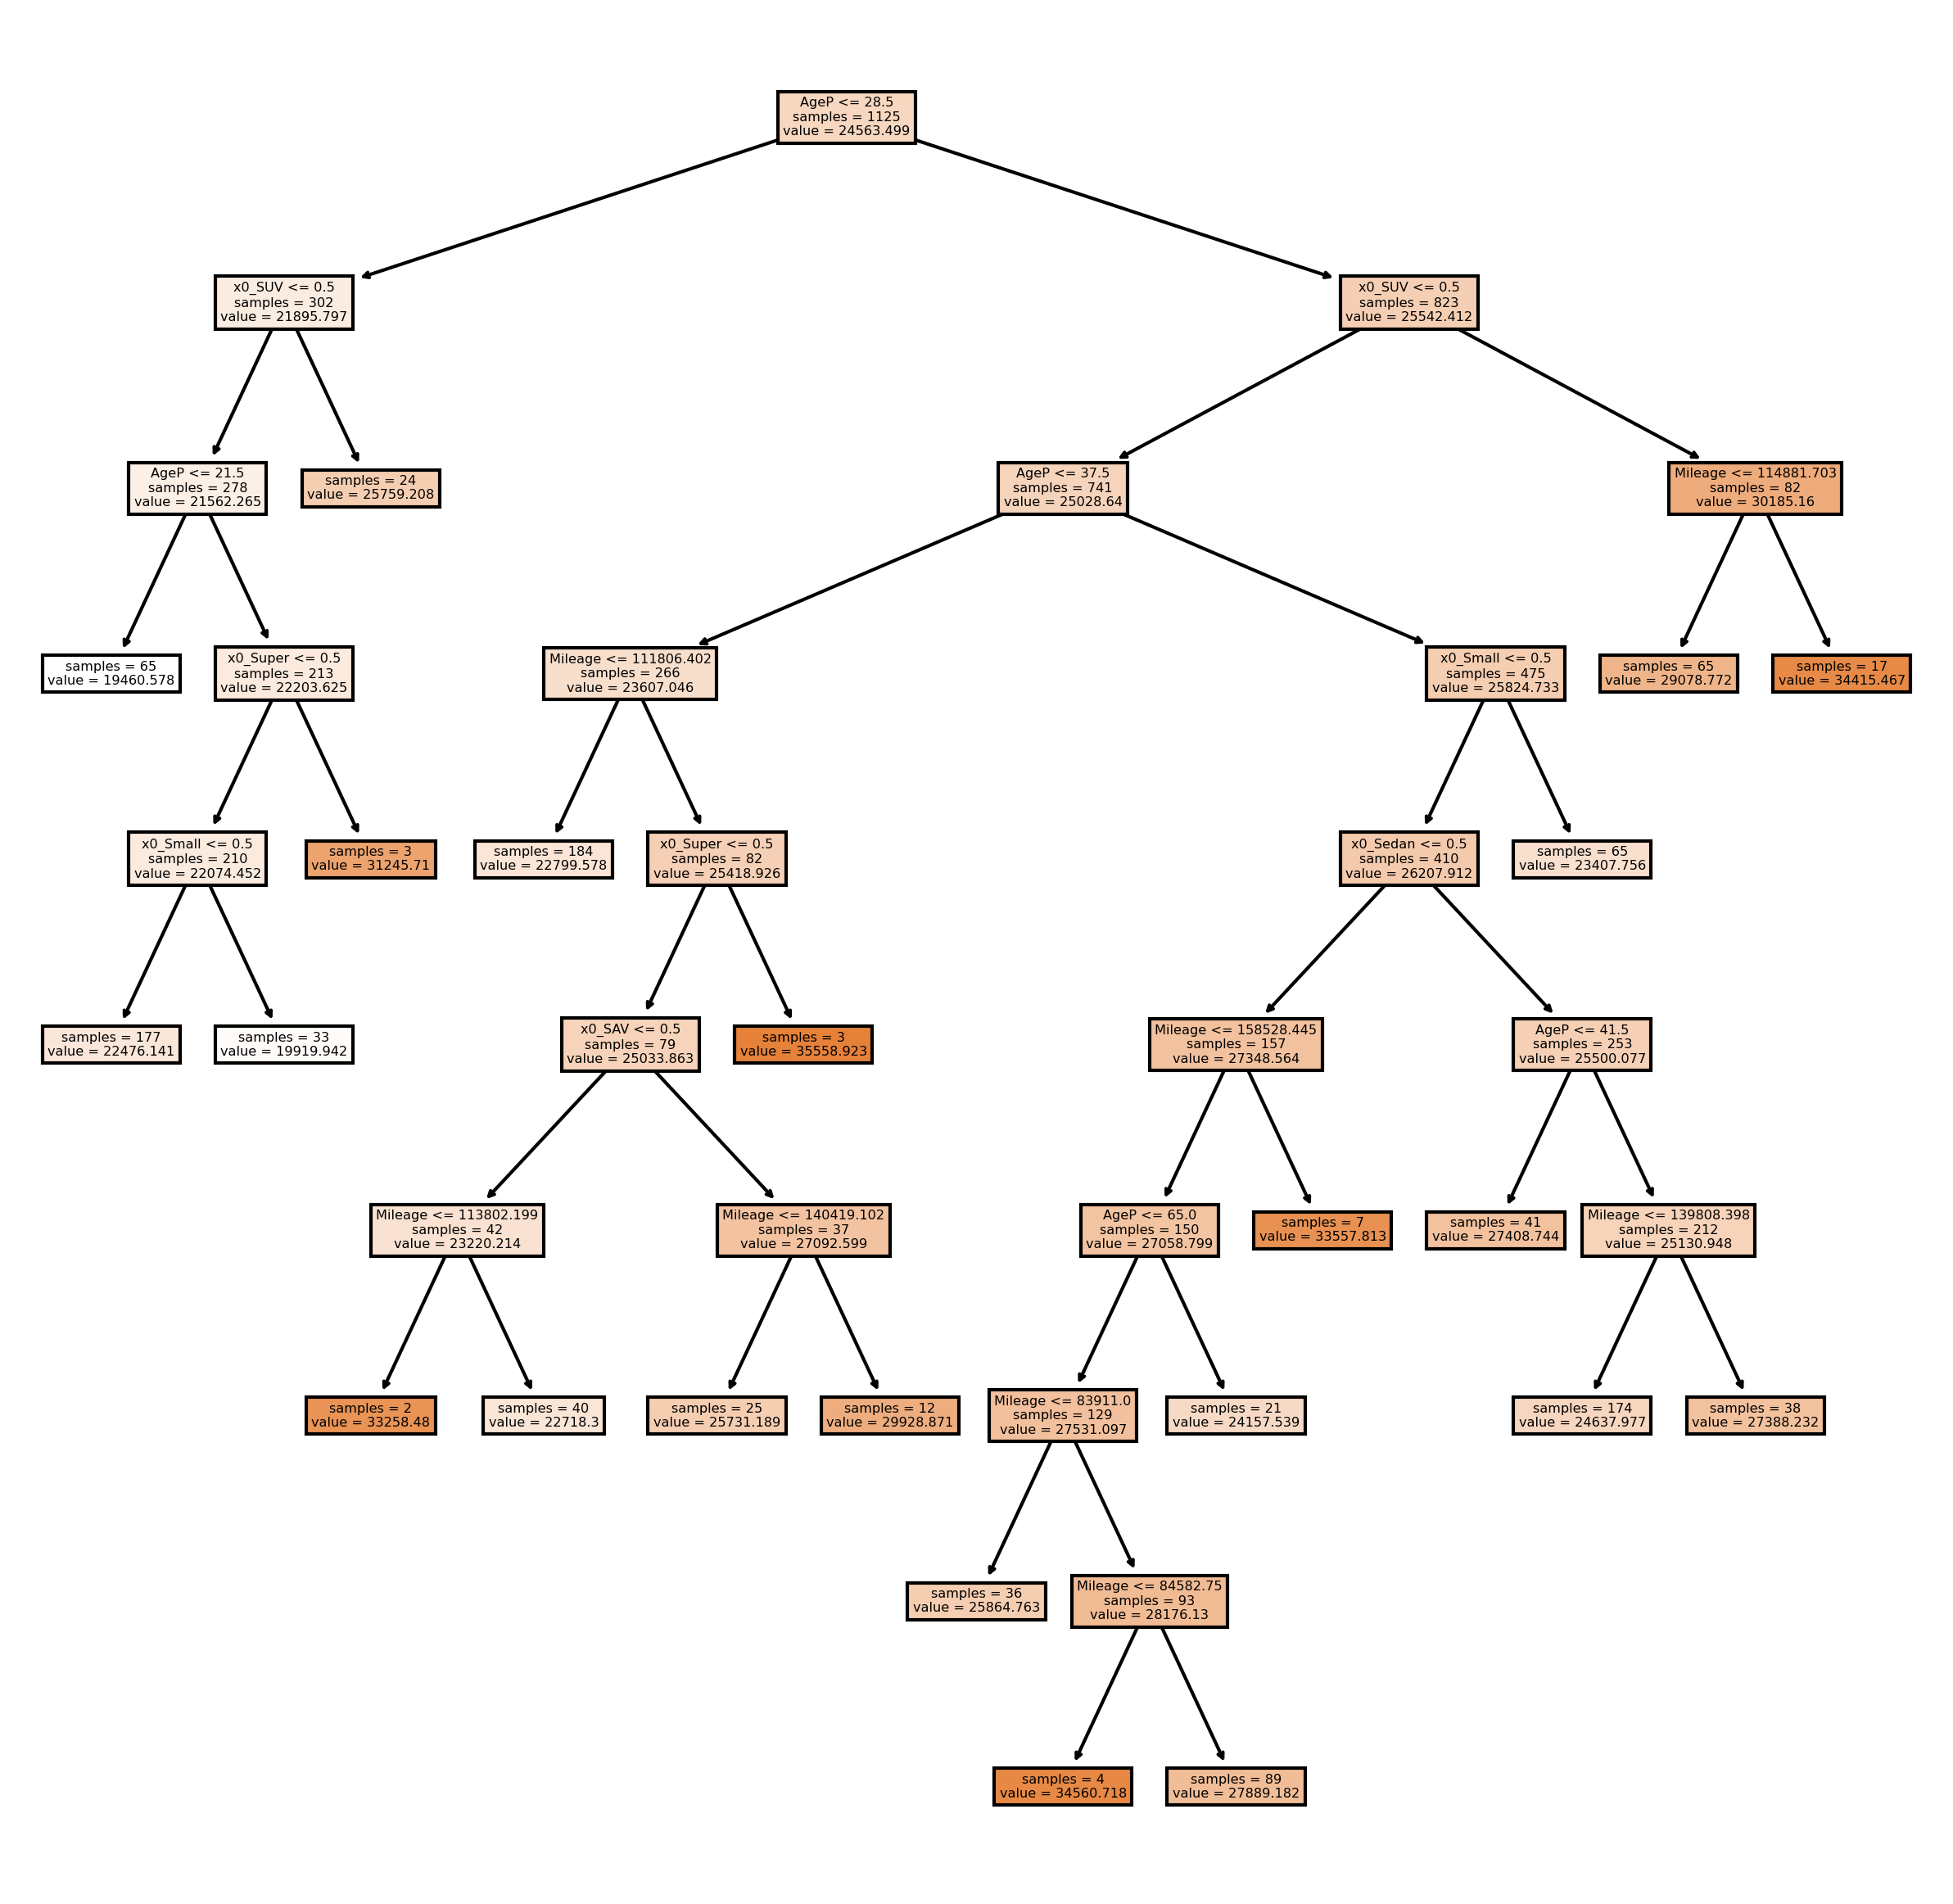

In [79]:
# Save the plot as an image to read the information in the nodes
plt.figure(figsize=[10,10], dpi=300)
plot_tree(reg4, 
          feature_names=X_train.columns, 
          filled=True,impurity=False)
 
plt.savefig('ClaimsDataSet_tree.png');

In [80]:
# Final test to see how the model performs: 

y_pred4 = reg4.predict(X_test)
error2 = mean_squared_error(y_test, y_pred4)

print("MSE before pruning = %s"%(error))
print("MSE of the optimal tree = %s"%(error2)) 

# This mean squared error is approximately half the unpruned tree's mean squared error

MSE before pruning = 51962957.46049439
MSE of the optimal tree = 29797332.627347138


In [81]:
# What is the final model to be used for predictions in future? 
best_model = DecisionTreeRegressor(random_state=0, max_leaf_nodes=22)
best_model.fit(X, y)
print("Tree depth =",best_model.get_depth(),'\n'
      "Number of leaves =",best_model.get_n_leaves())

Tree depth = 7 
Number of leaves = 22


Owners of new vehicles on average claimed R 23 435.09 compared to owners of pre-owned vehicles who claimed R 26 987.04 on average.  Owners of pre-owned vehicles claimed R 3 551,95 more than owners of new vehicles.  The difference is not significant but owners of pre-owned vehicles do claim more than owners of new vehicles.  One reason for the difference is that it can be more difficult and thus more expensive to find parts for older vehicles.  

Owners of Super vehicles claimed on average R 33 107,5 and owners of Small vehicles on average claimed R 21 458,09. That is a difference of R 11 649,41. The average claims value for the other categories is from highest to lowest:  SUV (R 29 439,96), SAV (R 25 567,22) and Sedan (R 23 759,34).  The reason for the significant difference between the vehicle category with the most claims and the vehicle category with the lowest claims is that the vehicles in the super category are luxury vehicles and thus more expensive than the vehicles in the small category.  Therefor it is more expensive to replace or fix cars from the super category.

## Part 2: Unsupervised learning

### 2.1 Import and explore the basic characteristics of the  fitness tracker data set

In [82]:
# Import libraries
# General 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import seaborn as sns

# For clustering algorithms
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist

# K-means clustering
from sklearn.cluster import KMeans

# Agglomerative hierarchical clustering
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

In [83]:
# Import data and print the shape of the data
df = pd.read_csv("../input/fitnesstrackerdata/FitnessTrackerData.txt",delimiter=" ")
print(df.shape)

(300, 3)


In [84]:
# Explore the type of data and feature names
df.sample(8)

Pace   Distance  Frequency
98   4.609772  13.488446   2.306895
83   5.018070  12.833635   2.741642
173  4.677663  15.050550   2.957452
84   3.806370  12.956223   2.280256
191  4.615539  16.563305   3.223947
260  4.569869  10.831815   1.053008
168  4.124176  14.531880   3.036129
40   4.962030  12.009585   1.962985

In [85]:
# For consistency, make the data X
X = df.copy()

### 2.2 Plot the data

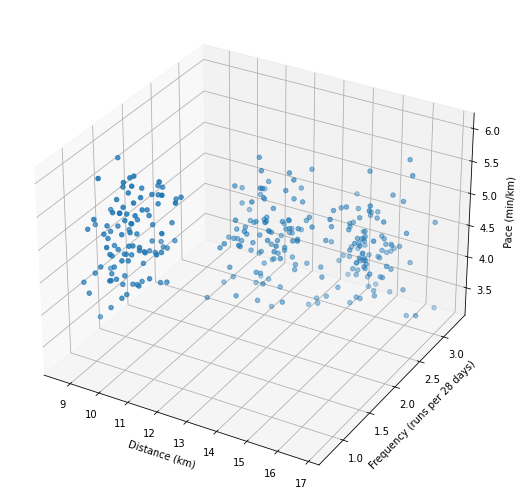

In [86]:
# Plot a three-dimensional plot of the data
fig = plt.figure(figsize=(9,9))
ax = plt.axes(projection="3d")

x_points = X.loc[:,"Distance"]
y_points = X.loc[:,"Frequency"]
z_points = X.loc[:,"Pace"]

ax.set_xlabel("Distance (km)")
ax.set_ylabel("Frequency (runs per 28 days)")
ax.set_zlabel("Pace (min/km)")

ax.scatter3D(x_points, y_points, z_points);

plt.show()

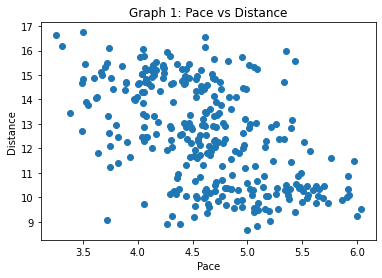

In [87]:
# Plot Pace vs Distance
plt.scatter(X.loc[:,"Pace"],X.loc[:,"Distance"])
plt.title('Graph 1: Pace vs Distance')
plt.xlabel('Pace')
plt.ylabel("Distance")
plt.show()

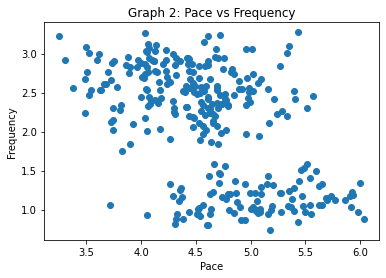

In [88]:
# Plot Pace vs Frequency
plt.scatter(X.loc[:,"Pace"],X.loc[:,"Frequency"])
plt.title('Graph 2: Pace vs Frequency')
plt.xlabel('Pace')
plt.ylabel('Frequency')
plt.show()

In [89]:
# Plot Distance vs Frequency
plt.scatter(X.loc[:,"Distance"],X.loc[:,"Frequency"])
plt.title('Graph 3: Distance vs Frequency')
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.show()

### 2.3 K-means clustering

#### 2.3.1 Find the optimal number of clusters

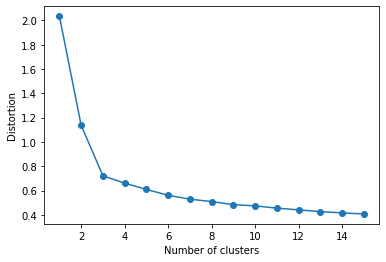

In [90]:
# 1. Elbow method 
# Calculate distortions 

distortions = []

for i in range(1, 16):
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, 
                max_iter=300,tol=1e-04, random_state=0)
    km.fit(X)
    distortions.append(sum(np.min(cdist(X, km.cluster_centers_, 
                      'euclidean'),axis=1)) / X.shape[0])

# Plot distortions
plt.plot(range(1, 16), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

In [91]:
# 2. Silhouette method 
sil = []
kmax = 10

for k in range(2, kmax+1):
  kmeans = KMeans(n_clusters = k).fit(X)
  labels = kmeans.labels_
  sil.append(silhouette_score(X, labels, metric = 'euclidean'))


# Plot
plt.plot(range(2, kmax+1), sil, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.show()

#### 2.3.2 Cluster the data using the scikit-learn K-means algorithm

In [92]:
# Cluster the data 
km = KMeans(n_clusters=3, init='k-means++', 
            n_init=10, max_iter=300, 
            tol=1e-04, random_state=0)
km.fit(X) 

KMeans(n_clusters=3, random_state=0)

In [93]:
# Add the cluster labels to the dataframe 
print("First few cluster labels:",km.labels_[:65])

print("Cluster 0 size: %s \nCluster 1 size: %s \nCluster 2 size: %s"
      % (len(km.labels_)- km.labels_.sum(), km.labels_.sum(), km.labels_.sum()))

Xnew = X.copy()
Xnew["CLUSTERS"] = km.labels_
Xnew.sample(8, random_state=0) 

First few cluster labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Cluster 0 size: 0 
Cluster 1 size: 300 
Cluster 2 size: 300


Pace   Distance  Frequency  CLUSTERS
208  5.734379   9.749187   1.175090         1
188  4.164663  15.184689   2.630416         2
12   4.551373  12.282242   2.262886         0
221  5.065831  11.281043   0.959691         1
239  4.765949  10.701846   1.560003         1
136  4.318200  14.652788   2.936755         2
230  5.393464  11.439544   0.975832         1
206  4.863134  10.926031   1.217446         1

#### 2.3.3 Plot the clusters generated by the K-means algorithm

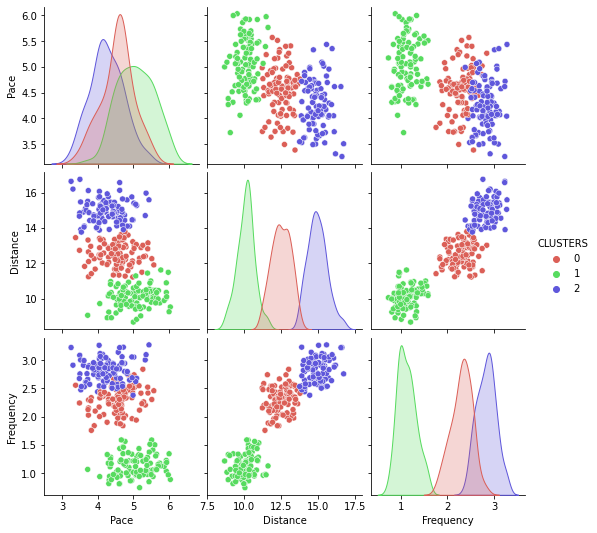

In [94]:
# Plot all variables and their clusters using seaborn 
var = ["Pace", "Distance","Frequency"]

# Plot using seaborn
sns.pairplot(Xnew, vars=var, hue="CLUSTERS", palette=sns.color_palette("hls", 3))

### 2.4 Hierarchical clustering

#### 2.4.1 Find the optimal number of clusters

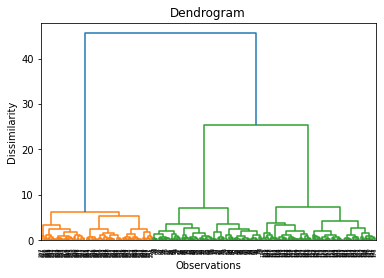

In [95]:
# Plot the dendrogram with linkage method = 'ward'
dendro = dendrogram(linkage(X, method  = "ward"))

# Note that it may take a while for this graph to be generated
plt.title('Dendrogram')
plt.ylabel('Dissimilarity')
plt.xlabel('Observations')
plt.show()

In [96]:
# Plot the dendrogram with linkage method = 'complete'

dendro = dendrogram(linkage(X, method  = "complete"))

# Note that it may take a while for this graph to be generated
plt.title('Dendrogram')
plt.ylabel('Dissimilarity')
plt.xlabel('Observations')
plt.show()

#### 2.4.2 Cluster the data using the scikit-learn `AgglomerativeClustering` algorithm

**Group the data into two clusters**

In [97]:
# Run the agglomerative clustering algorithm using two clusters
hc = AgglomerativeClustering(n_clusters = 2, affinity = 'euclidean', linkage ='ward')

y_hc=hc.fit_predict(X)

In [98]:
# Set up dataframe with cluster labels 
Xnew = X.copy()
Xnew["CLUSTERS"] = y_hc
Xnew.sample(10, random_state=0)

Pace   Distance  Frequency  CLUSTERS
208  5.734379   9.749187   1.175090         1
188  4.164663  15.184689   2.630416         0
12   4.551373  12.282242   2.262886         0
221  5.065831  11.281043   0.959691         1
239  4.765949  10.701846   1.560003         1
136  4.318200  14.652788   2.936755         0
230  5.393464  11.439544   0.975832         1
206  4.863134  10.926031   1.217446         1
52   4.981272  11.215898   2.508583         0
108  4.755913  14.431425   2.945011         0

**Plots with two clusters**

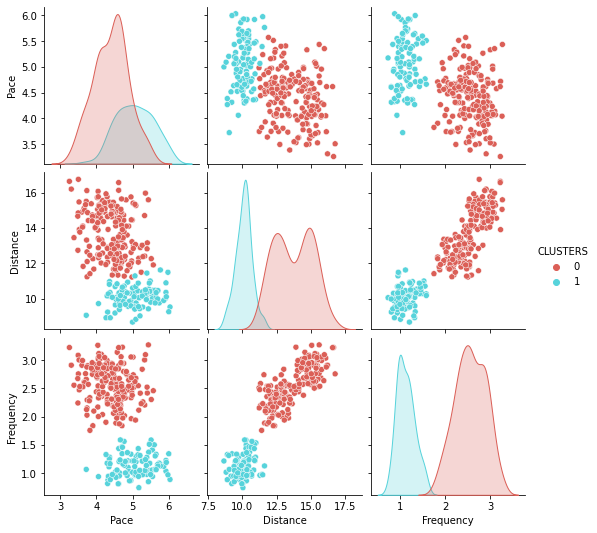

In [99]:
# Plot all the variables and their clusters using seaborn 
var = ["Pace", "Distance","Frequency"]

# Plot
sns.pairplot(Xnew, vars=var, hue="CLUSTERS", palette=sns.color_palette("hls", 2))

**Group the data into three clusters**

In [100]:
# Run the agglomerative clustering algorithm using three clusters and the linkage method of your choice 
hc = AgglomerativeClustering(n_clusters = 3, affinity = 'euclidean', linkage ='ward')

y_hc=hc.fit_predict(X)

In [101]:
# Set up dataframe with cluster labels 
Xnew = X.copy()
Xnew["CLUSTERS"] = y_hc
Xnew.sample(10, random_state=0)

Pace   Distance  Frequency  CLUSTERS
208  5.734379   9.749187   1.175090         1
188  4.164663  15.184689   2.630416         0
12   4.551373  12.282242   2.262886         2
221  5.065831  11.281043   0.959691         1
239  4.765949  10.701846   1.560003         1
136  4.318200  14.652788   2.936755         0
230  5.393464  11.439544   0.975832         1
206  4.863134  10.926031   1.217446         1
52   4.981272  11.215898   2.508583         2
108  4.755913  14.431425   2.945011         0

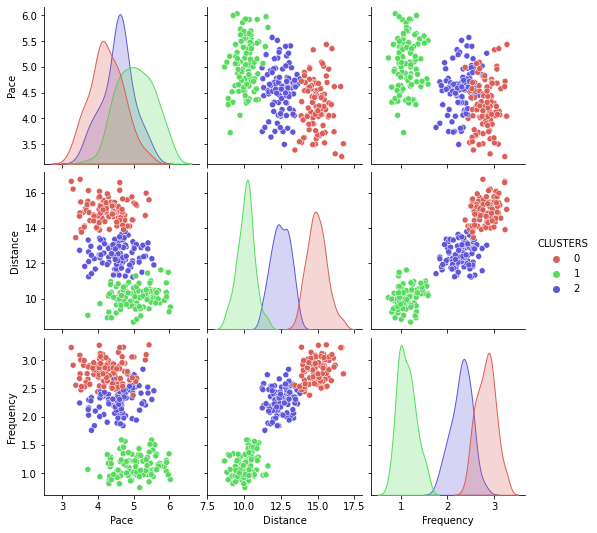

In [102]:
# Plot all the variables and their clusters using seaborn 
var = ["Pace", "Distance","Frequency"]

# Plot
sns.pairplot(Xnew, vars=var, hue="CLUSTERS", palette=sns.color_palette("hls", 3))

I used three clusters for K-means clustering.  I would recommend using three clusters.  When using two clusters the persons with high and medium frequency values are grouped in one cluster.  If three clusters is used the characteristics of persons with high, medium and low frequency values can be seen.  Using three clusters allows us to identify the characteristics of the persons with medium frequency values.  More conclusions can be drawn with three clusters.

•	Product 1: Beginner-level training programmes  
•	Product 2: Professional-level training programmes  
•	Product 3: Advanced analytics

I would recommend product 3 to the persons within cluster 3.  This is persons that exercise more frequently, covered more distance and has a slower pace.  Because persons in cluster  1 exercise more frequently they will be more interested in monitoring and analysing their exercise statistics.  Product 3 will probably also be more expensive.  People that are serious about exercising will be more likely to spend money on more expensive products.
People from cluster 0, exercise less frequently, covers a shorter distance and has a higher pace.  I would characterise people in this cluster 0 as beginners and would recommend product 1 to them.   Lastly I would recommend product 2 to people from cluster 2.
